In [1]:
import sys; sys.path.append('..')
import pyzx as zx
import random
import numpy as np
np.set_printoptions(precision=4,suppress=True)
%config InlineBackend.figure_format = 'svg'

# Spider QASM

Spider QASM, or SQASM, is a simple extension to the QASM circuit description language, which is convenient for expressing arbitrary ZX-diagrams. The only difference in SQASM and normal QASM is registers starting with a capital letter are treated in a special way.

If all the registers have lowercase names, the `sqasm` function produces a normal QASM circuit. The only difference is it fuses spiders of the same colour and eliminates identities:

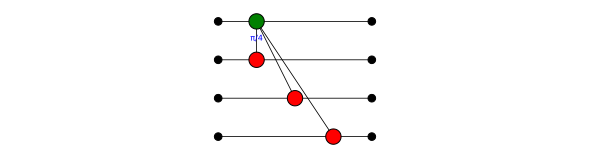

In [3]:
g = zx.sqasm("""
qreg q[4];
cx q[0], q[1];
cx q[0], q[2];
cx q[0], q[3];
t q[0];
""")
zx.draw(g)

We can supress this behaviour by passing in `simplify=False`:

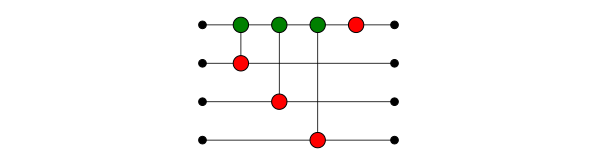

In [3]:
g = zx.sqasm("""
qreg q[4];
cx q[0], q[1];
cx q[0], q[2];
cx q[0], q[3];
rx(0pi) q[0];
""", simplify=False)
zx.draw(g)

If a register starts with a capital letter `A`, it is treated as an ancilla. A spider of the _same colour_ as the first spider on that qubit is plugged in, followed by simplification.

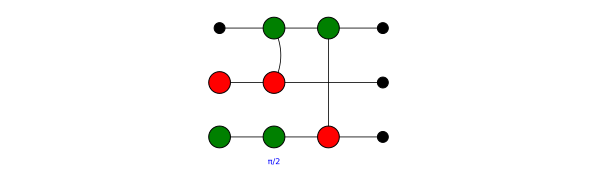

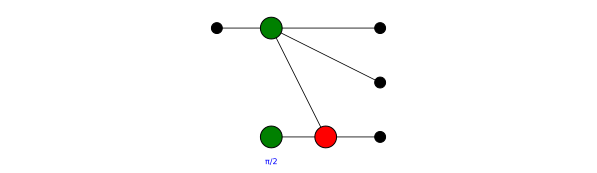

In [4]:
s = """
qreg q[1];
qreg A[2];
s A[1];
cx q[0], A[0];
cx q[0], A[1];
"""
display(
    zx.draw(zx.sqasm(s, simplify=False)),
    zx.draw(zx.sqasm(s))
)

Similarly, if a register starts with `Z`, it will be post-selected by plugging in a spider with the same colour as the last spider on that qubit:

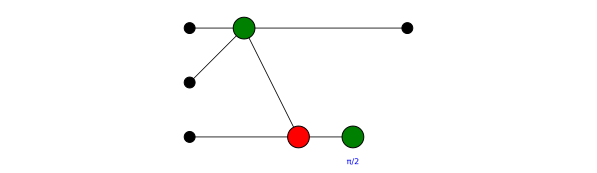

In [5]:
s = """
qreg q[1];
qreg Z[2];
cx q[0], Z[0];
cx q[0], Z[1];
s Z[1];
"""
zx.draw(zx.sqasm(s))

In particular, you can make Z-copy operations by setting an ancilla as the target of a CNOT and Z-merge by setting a post-selection as the target. You can make X-copy by setting an ancilla as the control qubit of a CNOT and X-merge by using a post-selection as the control.

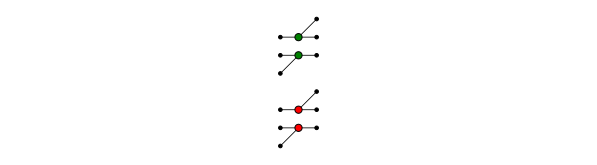

In [6]:
s = """
qreg Aa[1];
qreg qa[2];
qreg Za[1];
cx qa[0], Aa[0]; // Z-copy
cx qa[1], Za[0]; // Z-merge

qreg Ab[1];
qreg qb[2];
qreg Zb[1];
cx Ab[0], qb[0]; // X-copy
cx Zb[0], qb[1]; // X-merge
"""
zx.draw(zx.sqasm(s))

Finally, a register starting with any other capital letter has spiders (of matching colours) plugged into _both_ the input and the output.

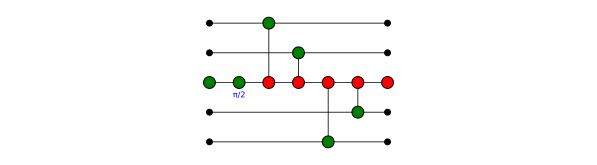

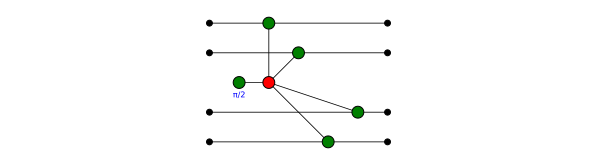

In [7]:
s = """
qreg q[2];
qreg G[1];
qreg r[2];
s G[0];
cx q[0], G[0];
cx q[1], G[0];
cx r[1], G[0];
cx r[0], G[0];
"""

display(
    zx.draw(zx.sqasm(s, simplify=False)),
    zx.draw(zx.sqasm(s))
)

Once you get used to these conventions, it is pretty easy to write down arbitrary ZX-diagrams as "pseudo-circuits". For example, the symmetrizer projection is a pretty elaborate, non-unitary ZX-diagram, which can be written as follows in SQASM:

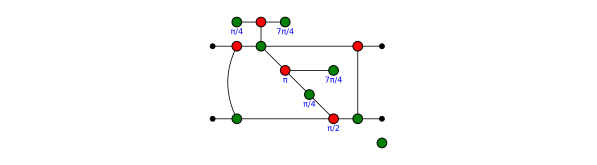

In [8]:
g = zx.sqasm("""
qreg S[1];
qreg q[1];
qreg T[2];
qreg r[1];
qreg U[1];

cx r[0], q[0];
t S[0];
cx q[0], S[0];
tdg S[0];
cx q[0], T[0];
x T[0];
cx T[1], T[0];
tdg T[0];
cx T[1], r[0];
t T[1];
rx(0.5pi) r[0];
cx r[0], q[0];
""")
zx.draw(g)

Note how, by using multiple registers, we can easily interleave spiders and qubit wires.

Checking the matrix of the diagram above, we obtain:

In [9]:
m = g.to_matrix()
m

array([[ 0.5 -0.j,  0.  +0.j,  0.  +0.j, -0.  +0.j],
       [ 0.  +0.j,  0.25-0.j,  0.25-0.j,  0.  +0.j],
       [ 0.  +0.j,  0.25-0.j,  0.25-0.j,  0.  +0.j],
       [-0.  +0.j,  0.  +0.j,  0.  +0.j,  0.5 -0.j]])

Note this actually returns $0.5$ times the symmetrizer. This is because, by default, `g.scalar` is chosen to make states and effects normalised and all gates unitary. As a consequence, the resulting map $m$ will always be a valid Kraus operator. That is, the CP-map $\rho \mapsto m \rho m^\dagger$ will be trace non-increasing.

To drop this convention and give the actual, un-normalised matrix defined by the ZX-diagram, pass `preserve_scalar=False`.

In [10]:
g.to_matrix(preserve_scalar=False)

array([[ 1. -0.j,  0. +0.j,  0. +0.j, -0. +0.j],
       [ 0. +0.j,  0.5-0.j,  0.5-0.j,  0. +0.j],
       [ 0. +0.j,  0.5-0.j,  0.5-0.j,  0. +0.j],
       [-0. +0.j,  0. +0.j,  0. +0.j,  1. -0.j]])